In [78]:
import torch
import pandas as pd
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 

training_data = pd.read_csv("training-val-test-data.csv", header=None)

In [11]:
import torch
import pandas as pd
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 

ulist = training_data.iloc[:, 0].tolist()[1:]   # Input voltage
ylist = training_data.iloc[:, 1].tolist()[1:]  # Output angle

ulist = [float(val) for val in ulist]
ylist = [float(val) for val in ylist]

na, nb = 5,5 # How many past data is used 

def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)


Xdata, Ydata = create_IO_data(ulist, ylist, na, nb)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata)
Xtrain, Xval = Xtrain[:5000], Xval
Ytrain, Yval = Ytrain[:5000], Yval

Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
Xval = torch.tensor(Xval, dtype=torch.float32)
Ytrain = torch.tensor(Ytrain, dtype=torch.float32)
Yval = torch.tensor(Yval, dtype=torch.float32)

import functools

class Simple_net(nn.Module):
    def __init__(self, n_in, n_hidden_layer, n_nodes_per_layer, activation):
        super().__init__()
        
        if n_hidden_layer==0: 
            seq = [nn.Linear(1,1)]
        else:
            seq = [nn.Linear(n_in,n_nodes_per_layer), activation()]
            for layer in range(n_hidden_layer-1):
                seq.extend([nn.Linear(n_nodes_per_layer,n_nodes_per_layer), activation()])
            seq.append(nn.Linear(n_nodes_per_layer,1))
        
        self.non_lin_net = nn.Sequential(*seq)
    
    def forward(self, x):
        return self.non_lin_net(x[:,None])[:,0]
    
def fit(net, X_data, Y_data, X_val, Y_val, epochs=600):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
    best_state = None
    best_loss = float('inf')
    
    for epoch in range(1,epochs+1):
        loss = torch.mean((net(X_data)-Y_data)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%200==0:
            loss_val = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #RMS
            if loss_val<best_loss:
                from copy import deepcopy
                best_state = deepcopy(net.state_dict())
                best_loss = loss_val
            print(f'epoch={epoch:5}, loss={loss.item()**0.5:.8f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.lru_cache(maxsize=500, typed=False)
def test(X_train, Y_train, X_val, Y_val, n_in, n_hidden_layer=2, n_nodes_per_layer=20, activation=nn.Tanh):
    net = Simple_net(n_in, n_hidden_layer, n_nodes_per_layer, activation) 
    net = fit(net, X_train, Y_train, X_val, Y_val) 
    RMS = torch.mean((net(X_val)-Y_val)**2).item()**0.5 
    return RMS 


### The optimizer for finding number of layers, number of nodes per layer and activation function

In [216]:
#a basic optimizer 
current_best = dict(n_hidden_layer=3, n_nodes_per_layer=16, activation=nn.Sigmoid)
choices_dict = dict(n_hidden_layer=[1,2,3], \
               n_nodes_per_layer=[16,32,50], \
               activation=[nn.Tanh,nn.ReLU,nn.ELU,nn.Sigmoid])

import copy
for it in range(30):
    last_best = copy.deepcopy(current_best)
    
    for name, choices in choices_dict.items(): #iterate over the n_hidden_layer, n_nodes_per_layer, activation
        results = []
        for choice in choices: #check each candidate
            now = copy.deepcopy(current_best) #create a new dict
            now[name] = choice #put choice in the correct place
            print('optimizing...',now) 
            results.append(test(Xtrain, Ytrain, Xval, Yval, Xtrain.shape[1], **now)) #add it to results
            

        print('done with loop for option', name)
        print('\n'.join([f'choice={c} result={r:.8}' for c,r in zip(choices,results)]))
        pick = choices[np.argmin(results)]
        print(f'picking = {pick} {name}')
        current_best[name] = pick
    
    if last_best==current_best:
        print('no change deteched, optimization complete')
        print(f'completed with {current_best}')
        break

optimizing... {'n_hidden_layer': 1, 'n_nodes_per_layer': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch=  200, loss=0.47827454
epoch=  400, loss=0.47826915
epoch=  600, loss=0.47826810
optimizing... {'n_hidden_layer': 2, 'n_nodes_per_layer': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch=  200, loss=0.47826718
epoch=  400, loss=0.47826694
epoch=  600, loss=0.47826689
optimizing... {'n_hidden_layer': 3, 'n_nodes_per_layer': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch=  200, loss=0.47826689
epoch=  400, loss=0.47826687
epoch=  600, loss=0.47826687
done with loop for option n_hidden_layer
choice=1 result=0.48285265
choice=2 result=0.48285135
choice=3 result=0.48285129
picking = 3 n_hidden_layer
optimizing... {'n_hidden_layer': 3, 'n_nodes_per_layer': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
optimizing... {'n_hidden_layer': 3, 'n_nodes_per_layer': 32, 'activation': <class 'torch.nn.modules.ac

Training and prediction RMS with model from grid search


In [96]:
import torch
import pandas as pd
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

training_data = pd.read_csv("training-val-test-data.csv", header=None)

# Extract and convert the data to floats
ulist = training_data.iloc[:, 0].tolist()[1:]
ylist = training_data.iloc[:, 1].tolist()[1:]
ulist = [float(val) for val in ulist]
ylist = [float(val) for val in ylist]

na, nb = 5, 5  # Number of past data points used

# Function to create input-output pairs
def create_IO_data(u, y, na, nb):
    X = []
    Y = []
    for k in range(max(na, nb), len(y)):
        X.append(np.concatenate([u[k-nb:k], y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

Xdata, Ydata = create_IO_data(ulist, ylist, na, nb)

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)

# Standardize the data
scaler_X = StandardScaler().fit(Xtrain)
scaler_Y = StandardScaler().fit(Ytrain.reshape(-1, 1))

Xtrain = scaler_X.transform(Xtrain)
Xval = scaler_X.transform(Xval)
Xdata = scaler_X.transform(Xdata)
Ytrain = scaler_Y.transform(Ytrain.reshape(-1, 1)).flatten()
Yval = scaler_Y.transform(Yval.reshape(-1, 1)).flatten()

Xtrain = torch.tensor(Xtrain, dtype=torch.float64)
Xval = torch.tensor(Xval, dtype=torch.float64)
Ytrain = torch.tensor(Ytrain, dtype=torch.float64)
Yval = torch.tensor(Yval, dtype=torch.float64)
Xdata = torch.tensor(Xdata, dtype=torch.float64)

class Network(nn.Module):
    def __init__(self, n_in, n_hidden_nodes):
        super(Network, self).__init__()
        self.lay1 = nn.Linear(n_in, n_hidden_nodes).double()
        self.lay2 = nn.Linear(n_hidden_nodes, n_hidden_nodes).double()
        self.lay3 = nn.Linear(n_hidden_nodes, n_hidden_nodes).double()
        self.lay4 = nn.Linear(n_hidden_nodes, 1).double()
    
    def forward(self, x):
        x1 = torch.relu(self.lay1(x))
        x2 = torch.relu(self.lay2(x1))
        x3 = torch.relu(self.lay3(x2))
        y = self.lay4(x3)[:, 0]
        return y

n_hidden_nodes = 16
epochs = 1000

model = Network(Xtrain.shape[1], n_hidden_nodes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
import time
t_start = time.time() #current time in seconds
batch_size = 128 
batched = True  

for epoch in range(epochs):
    if batched: 
        dummy = 1 
        for i in range(0, len(Xtrain)-batch_size, batch_size): #e)
            Loss = torch.mean((model(Xtrain[i:i+batch_size])-Ytrain[i:i+batch_size])**2) #e)
            optimizer.zero_grad() #e)
            Loss.backward() #e)
            optimizer.step() #e)
    else:
        Loss = torch.mean((model(Xtrain) - Ytrain) ** 2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(epoch, Loss.item())

torch.save(model.state_dict(), "ANN_model.pth")




0 0.005672847967200084
100 4.3816585641787685e-05
200 4.6585777138743794e-05
300 4.395464105196034e-05
400 4.383212893936873e-05
500 4.4469658469124547e-05
600 4.6039553699620805e-05
700 4.618742807338698e-05
800 4.561502758777149e-05
900 4.517760674181103e-05


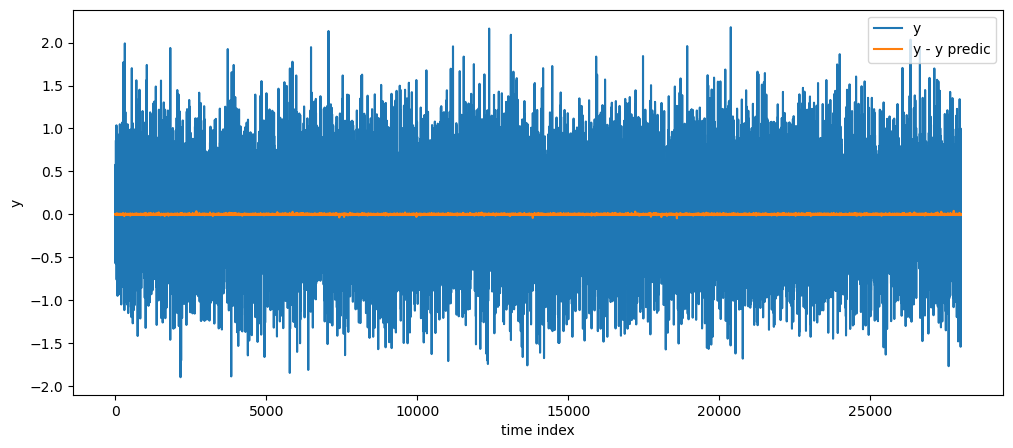

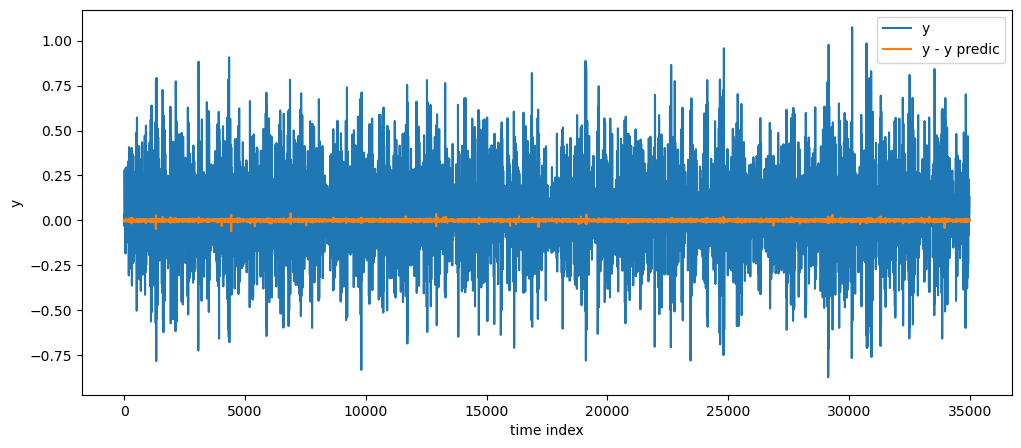

RMSE prediction 0.0032720058682741875


In [97]:
with torch.no_grad():
    Ytrain_pred = model(Xtrain)
    Ytrain_pred_denorm = torch.tensor(scaler_Y.inverse_transform(Ytrain_pred.reshape(-1, 1)).flatten())
    Ytrain_denorm = torch.tensor(scaler_Y.inverse_transform(Ytrain.reshape(-1, 1)).flatten())
    res = Ytrain_pred_denorm - Ytrain_denorm
    
    plt.figure(figsize=(12, 5))
    plt.plot(Ytrain_denorm.numpy())
    plt.plot(res.numpy())
    plt.xlabel('time index')
    plt.ylabel('y')
    plt.legend(['y', 'y - y predic'])
    plt.show()
    
    Yval_pred = model(Xdata)
    Yval_pred_denorm = torch.tensor(scaler_Y.inverse_transform(Yval_pred.reshape(-1, 1)).flatten())
    res = Yval_pred_denorm - Ydata
    
    plt.figure(figsize=(12, 5))
    plt.plot(Yval_denorm)
    plt.plot(res.numpy())
    plt.xlabel('time index')
    plt.ylabel('y')
    plt.legend(['y', 'y - y predic'])
    plt.show()
    
    print('RMSE prediction', torch.sqrt(torch.mean(res**2)).item())

In [100]:
missing = 35000 - len(Xdata)
zero_tensor = np.zeros((missing, na + nb))
Xdata = np.concatenate((Xdata,zero_tensor))

assert len(Yval_denorm)==len(Xdata), 'number of samples changed!!'

np.savez('ann_prediction_submission.npz', upast=Xdata, thnow=Yval_denorm)
